In [1]:
import pod5
import numpy as np
import random
import matplotlib.pyplot as plt
import matplotlib as mpl
import sys
mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['font.size'] = 12
import os
import sys
sys.path.insert(0, '/private/groups/brookslab/gabai/tools/NEMO/src/')
import importlib
from predict import *
from plot import *
importlib.reload(sys.modules['predict'])
importlib.reload(sys.modules['plot'])

<module 'plot' from '/private/groups/brookslab/gabai/tools/NEMO/src/plot.py'>

In [2]:
dt_outpath = '../data/'
fig_outpath = '../figures/manuscript_figures/'

In [ ]:
neg_bam = '/private/groups/brookslab/gabai/projects/Add-seq/data/ctrl/pod5/220308_ang_0.sorted.bam'
pos_bam = '/private/groups/brookslab/gabai/projects/Add-seq/data/ctrl/pod5/220308_ang_500.sorted.bam'
chrom_rep1_bam = '/private/groups/brookslab/gabai/projects/Add-seq/data/chrom/mapping/20190429_chrom.sorted.bam'
sphe_bam = '/private/groups/brookslab/gabai/projects/Add-seq/data/chrom/sphe/220524_500Ang_Spheroblast_dorado_movesOut_sorted.bam'

In [3]:
# rep1
chrom_190429_agg = '../data/prediction/aggregate/240912_dorado_20190429_chrom_window2000_nuc_aggregate_score.tsv'
# rep2
chrom_210615_agg = '../data/prediction/aggregate/240922_dorado_20210615_chrom_window2000_nuc_aggregate_score.tsv'
# sphe
chrom_sphe_agg = '../data/prediction/aggregate/240909_dorado_sphe_using_nuclei_model_window2000_nuc_aggregate_score.tsv'
# neg ctrl
neg_ctrl_agg ='../data/prediction/aggregate/240911_dorado_220308_ang_0_window2000_nuc_aggregate_score.tsv'
# pos ctrl
pos_ctrl_agg ='../data/prediction/aggregate/240911_dorado_220308_ang_500_window2000_nuc_aggregate_score.tsv'

## Figure 2D

In [10]:
import pysam

In [408]:
def load_pred(predfile):
    readtomod = {}
    with open(predfile, 'r') as infile:
        for line in tqdm(infile):
            chrom = line.strip().split('\t')[1]
            readname = line.strip().split('\t')[0]
            strand = 1 if line.strip().split('\t')[2] == '+' else -1
            start = int(line.strip().split('\t')[3])
            scores = line.strip().split('\t')[-1]
            scores = np.array([round(float(i), 0) for i in scores.split(',')], dtype=np.uint8)
            modpos = np.array([start+i for i in range(len(scores))])
            readtomod[readname] = (scores, modpos)
    return readtomod

def get_modDist(bam, pred, cutoff = 180, subset = 1):

    samfile = pysam.AlignmentFile(bam, "rb")
    dist_angs = []
    seqlens = 0
    d = 0
    avemods = []
    all_mods = []
    for s in samfile:
        if s.is_mapped and not s.is_secondary and not s.is_supplementary:
            d += 1
            if not d%subset == 0: continue
            base_qualities = s.query_qualities
            # skip low quality reads
            if sum(base_qualities) / len(base_qualities) < 10: continue
            seqlens += len(s.query_sequence)
            astart, aend = s.reference_start, s.reference_end
            readname = s.query_name
            if readname not in pred: continue
            
            refseq = np.frombuffer(bytes(s.get_reference_sequence(), "utf-8"), dtype="S1")
            mods = pred[readname][0]
            modpos = pred[readname][1]
            
            avemods.append(np.mean(mods))
            all_mods.extend(mods)
            mods = mods[(modpos >= astart) & (modpos < aend)]
            modpos = modpos[(modpos >= astart) & (modpos < aend)]
            if modpos.shape[0] < len(refseq):
                refseq = refseq[:modpos.shape[0]]

            # if only consider TA positions
            # modbase = (b"A", b"T") if s.is_reverse else (b"T", b"A")
            # posTA_mask = (refseq[:-1] == modbase[0]) & (refseq[1:] == modbase[1])
            # # omit last item becasue no dimer
            # posTA_mod = mods[:-1][posTA_mask]
            # posTA = np.argwhere(posTA_mask).transpose()[0]
            # posTA_ang_musk = posTA_mod >= cutoff
            # posT_ang = posTA[posTA_ang_musk]

            # if consider all T
            # modbase = b"A" if s.is_reverse else b"T"
            # posT_mask = refseq == modbase
            # posT_mod = mods[posT_mask]
            # posT = np.argwhere(posT_mask).transpose()[0]
            # posT_ang_musk = posT_mod >= cutoff
            # posT_ang = posT[posT_ang_musk]

            # if consider all T/A
            posT_mask = (refseq == b"A") | (refseq == b"T")
            posT_mod = mods[posT_mask]
            posT = np.argwhere(posT_mask).transpose()[0]
            posT_ang_musk = posT_mod >= cutoff
            posT_ang = posT[posT_ang_musk]

            # if consider all positions
            # pos_ang_musk = mods >= cutoff
            # posT_ang = modpos[pos_ang_musk]
            
            
            dist_ang = np.diff(posT_ang)
            dist_angs.extend(dist_ang)
    return dist_angs, seqlens, all_mods

In [328]:
neg_pred = load_pred('../data/prediction/250219_dorado_220308_ang_0.tsv')
pos_pred = load_pred('../data/prediction/250219_dorado_220308_ang_500.tsv')
chrom_rep1 = load_pred('../data/prediction/240912_dorado_20190429_chrom.tsv')
chrom_sphe = load_pred('../data/prediction/240909_dorado_sphe_using_nuclei_model.tsv')


0it [00:00, ?it/s]
8it [00:00, 70.19it/s]
21it [00:00, 80.42it/s]
37it [00:00, 93.24it/s]
62it [00:00, 112.24it/s]
78it [00:00, 122.19it/s]
92it [00:00, 114.93it/s]
113it [00:00, 126.38it/s]
127it [00:00, 122.28it/s]
140it [00:01, 114.35it/s]
152it [00:01, 70.17it/s] 
162it [00:01, 73.86it/s]
182it [00:01, 90.60it/s]
195it [00:01, 95.91it/s]
210it [00:01, 107.20it/s]
224it [00:01, 115.30it/s]
239it [00:02, 116.97it/s]
257it [00:02, 130.51it/s]
272it [00:02, 132.59it/s]
290it [00:02, 142.89it/s]
306it [00:02, 129.37it/s]
322it [00:02, 119.64it/s]
335it [00:02, 116.33it/s]
351it [00:02, 124.55it/s]
376it [00:03, 145.85it/s]
393it [00:03, 140.27it/s]
415it [00:03, 151.38it/s]
445it [00:03, 175.63it/s]
465it [00:03, 180.83it/s]
485it [00:03, 177.08it/s]
504it [00:03, 170.93it/s]
525it [00:03, 170.54it/s]
543it [00:04, 138.79it/s]
559it [00:04, 140.65it/s]
576it [00:04, 147.34it/s]
595it [00:04, 157.45it/s]
617it [00:04, 170.69it/s]
635it [00:04, 136.39it/s]
656it [00:04, 147.77it/s]
673it

In [412]:
neg_distances, neg_seqlens, neg_avemods = get_modDist(neg_bam, neg_pred_new, cutoff = 150, subset=1)
pos_distances, pos_seqlens, pos_avemods = get_modDist(pos_bam, pos_pred_new, cutoff = 150, subset=1)
chrom_distances, chrom_seqlens, chrom_avemods = get_modDist(chrom_rep1_bam, chrom_rep1, cutoff = 1, subset=1)
sphe_distances, sphe_seqlens, sphe_avemods = get_modDist(sphe_bam, chrom_sphe, cutoff = 150, subset=1)

In [ ]:
plt.figure(figsize=(6, 4))
labels = ['negative control', '500uM positive control', 'Nuclei rep1', 'Spheroplast']
colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:purple']
avemods = [neg_avemods, pos_avemods, chrom_avemods, sphe_avemods]
for i in range(len(avemods)):
    print('start plotting...')
    # thiscount, thisbin = np.histogram(avemods[i], bins=np.arange(0, 255, 5), density=True)
    # counts.append(thiscount)
    # bins.append(thisbin)
    kde = stats.gaussian_kde(avemods[i])
    x = np.arange(0, 255, 1)
    density = kde(x)
    plt.plot(x, density, label=labels[i], color = colors[i])
    plt.bar(x, density, width = 1, alpha = 0.6,color = colors[i], linewidth=1)
plt.legend()
plt.xticks(np.arange(0, 255, 50))
plt.xlim(0, 255)
plt.xlabel('predicted modification score per read')
plt.ylabel('density')
plt.savefig(fig_outpath+ 'Figure2D_kde.pdf', bbox_inches='tight')

start plotting...
start plotting...
start plotting...
start plotting...


start plotting...
start plotting...
start plotting...
start plotting...


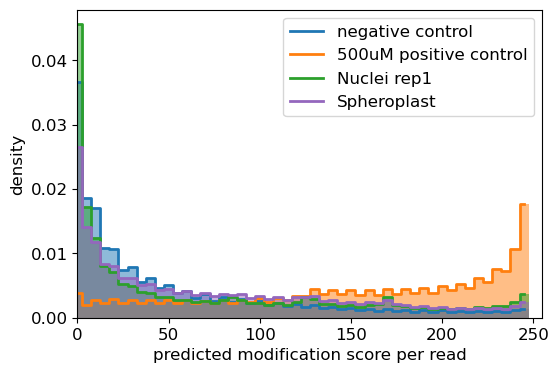

In [414]:
plt.figure(figsize=(6, 4))
labels = ['negative control', '500uM positive control', 'Nuclei rep1', 'Spheroplast']
colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:purple']
avemods = [neg_avemods, pos_avemods, chrom_avemods, sphe_avemods]
counts, bins = [], []
for i in range(len(avemods)):
    print('start plotting...')
    thiscount, thisbin = np.histogram(avemods[i], bins=np.arange(0, 255, 5), density=True)
    counts.append(thiscount)
    bins.append(thisbin)
    plt.bar(thisbin[:-1], thiscount, width = 5, alpha = 0.5, color = colors[i], linewidth=1)
    plt.step(thisbin[:-1], thiscount, where='mid', color=colors[i], linewidth=2, label=labels[i])
plt.legend()
plt.xticks(np.arange(0, 255, 50))
plt.xlim(0, 255)
plt.xlabel('predicted modification score per read')
plt.ylabel('density')
plt.savefig(fig_outpath+ 'Figure2D_hist.pdf', bbox_inches='tight')

In [403]:
neg_distances, neg_seqlens, neg_avemods = get_modDist(neg_bam, neg_pred_new, cutoff = 150)
pos_distances, pos_seqlens, pos_avemods = get_modDist(pos_bam, pos_pred_new, cutoff = 150)
chrom_distances, chrom_seqlens, chrom_avemods = get_modDist(chrom_rep1_bam, chrom_rep1, cutoff = 150)
sphe_distances, sphe_seqlens, sphe_avemods = get_modDist(sphe_bam, chrom_sphe, cutoff = 150)

500 reads processed
1000 reads processed
1500 reads processed
2000 reads processed
2500 reads processed
3000 reads processed
3500 reads processed
4000 reads processed
4500 reads processed
5000 reads processed
5500 reads processed
6000 reads processed
6500 reads processed
7000 reads processed
7500 reads processed
8000 reads processed
8500 reads processed
9000 reads processed
9500 reads processed
10000 reads processed
10500 reads processed
11000 reads processed
11500 reads processed
12000 reads processed
12500 reads processed
13000 reads processed
13500 reads processed
14000 reads processed
14500 reads processed
15000 reads processed
15500 reads processed
16000 reads processed
16500 reads processed
17000 reads processed
17500 reads processed
18000 reads processed
18500 reads processed
19000 reads processed
19500 reads processed
20000 reads processed
20500 reads processed
21000 reads processed
21500 reads processed
22000 reads processed
22500 reads processed
23000 reads processed
23500 re

start plotting...
start plotting...
start plotting...
start plotting...


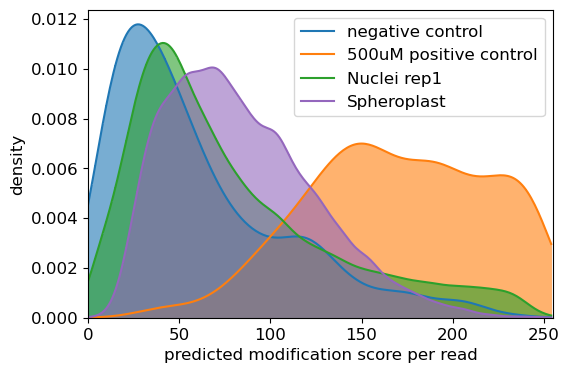

In [380]:
plt.figure(figsize=(6, 4))
labels = ['negative control', '500uM positive control', 'Nuclei rep1', 'Spheroplast']
colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:purple']
avemods = [neg_avemods, pos_avemods, chrom_avemods, sphe_avemods]
counts, bins = [], []
for i in range(len(avemods)):
    print('start plotting...')
    # thiscount, thisbin = np.histogram(avemods[i], bins=np.arange(0, 255, 5), density=True)
    # counts.append(thiscount)
    # bins.append(thisbin)
    kde = stats.gaussian_kde(avemods[i])
    x = np.arange(0, 255, 1)
    density = kde(x)
    plt.plot(x, density, label=labels[i], color = colors[i])
    plt.bar(x, density, width = 1, alpha = 0.6,color = colors[i], linewidth=1)
plt.legend()
plt.xticks(np.arange(0, 255, 50))
plt.xlim(0, 255)
plt.xlabel('predicted modification score per read')
plt.ylabel('density')

start plotting...
start plotting...
start plotting...
start plotting...


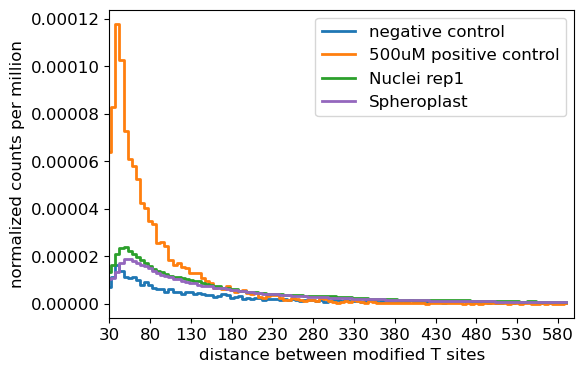

In [404]:
plt.figure(figsize=(6, 4))
labels = ['negative control', '500uM positive control', 'Nuclei rep1', 'Spheroplast']
colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:purple']
distances = [neg_distances, pos_distances, chrom_distances, sphe_distances]
seqlens = [neg_seqlens, pos_seqlens, chrom_seqlens, sphe_seqlens]

counts, bins = [], []

for i in range(len(distances)):
    print('start plotting...')

    thiscount, thisbin = np.histogram(distances[i], bins=np.arange(30, 600, 5), density=True)
    counts.append(thiscount)
    bins.append(thisbin)
    normalized_counts = (thiscount/seqlens[i])*1000000
    plt.step(
        thisbin[:-1],
        normalized_counts,
        where='mid',
        color=colors[i],
        linewidth=2,          # Outer line thickness
        label=labels[i])
plt.legend()
plt.xticks(np.arange(30, 600, 50))
plt.xlim(30, 600)
plt.xlabel('distance between modified T sites')
plt.ylabel('normalized counts per million')

start plotting...
start plotting...
start plotting...
start plotting...


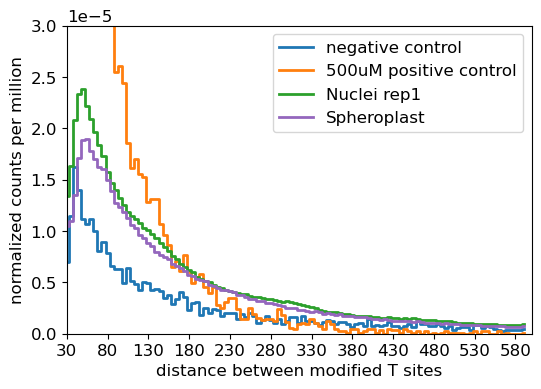

In [405]:
plt.figure(figsize=(6, 4))
labels = ['negative control', '500uM positive control', 'Nuclei rep1', 'Spheroplast']
colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:purple']
distances = [neg_distances, pos_distances, chrom_distances, sphe_distances]
seqlens = [neg_seqlens, pos_seqlens, chrom_seqlens, sphe_seqlens]

counts, bins = [], []

for i in range(len(distances)):
    print('start plotting...')

    thiscount, thisbin = np.histogram(distances[i], bins=np.arange(30, 600, 5), density=True)
    counts.append(thiscount)
    bins.append(thisbin)
    normalized_counts = (thiscount/seqlens[i])*1000000
    # plt.plot(thisbin[:-1], normalized_counts, alpha = 1, label=labels[i], color = colors[i], linewidth=1)
    # plt.bar(thisbin[:-1], normalized_counts, width = 5, alpha = 0.6, label=labels[i], color = colors[i], linewidth=1)
    plt.step(
        thisbin[:-1],
        normalized_counts,
        where='mid',
        color=colors[i],
        linewidth=2,          # Outer line thickness
        label=labels[i])
plt.legend()
plt.xticks(np.arange(30, 600, 50))
plt.xlim(30, 600)
plt.ylim(0, 3e-5)
plt.xlabel('distance between modified T sites')
plt.ylabel('normalized counts per million')

## Figure E

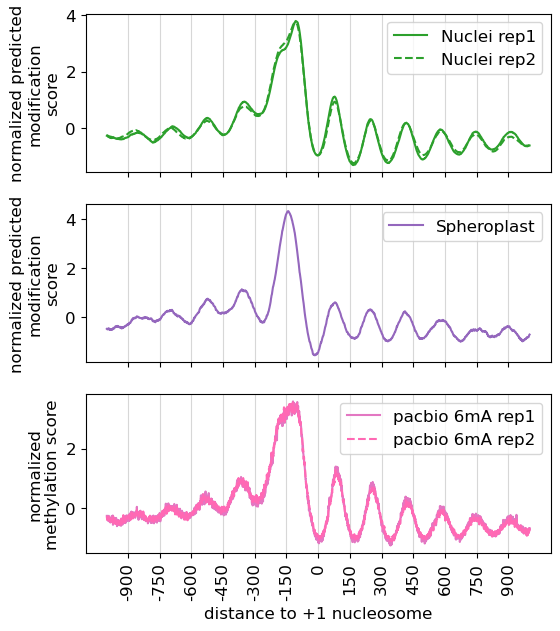

In [26]:

fig, [ax1, ax2, ax3] = plt.subplots(3, 1, figsize=(6,7))

hw = int(2000/2)
space=150
allagg = [chrom_190429_agg, chrom_210615_agg]
labels = ['Nuclei rep1', 'Nuclei rep2']
colors = ['tab:green', 'tab:green']
ls = ['-', '--']

for i in range(len(allagg)):
    with open(allagg[i], 'r') as infile:
        agg_scores = []
        for line in infile:
            line = line.strip().split('\t')
            agg_scores.append(float(line[1]))
        agg_scores=np.array(agg_scores)/255
        mean, std = np.mean(agg_scores), np.std(agg_scores)
        agg_scores = (agg_scores-mean)/std
        ax1.plot(np.arange(-hw, hw+1), agg_scores, label = labels[i], color=colors[i], ls = ls[i], alpha=1)

ax1.grid(alpha=0.5,axis = 'x')
ax1.legend(loc='upper right')
x_ticks = np.concatenate((np.flip(np.arange(0, -hw-1, -space)[1:]), np.arange(0, hw+1, space)), axis=0)
ax1.set_xticks(x_ticks)
ax1.set_xticklabels('', rotation='vertical')
ax1.set_ylabel('normalized predicted\nmodification\nscore')


with open(chrom_sphe, 'r') as infile:
    agg_scores = []
    for line in infile:
        line = line.strip().split('\t')
        agg_scores.append(float(line[1]))
    agg_scores=np.array(agg_scores)/255
    mean, std = np.mean(agg_scores), np.std(agg_scores)
    agg_scores = (agg_scores-mean)/std
    ax2.plot(np.arange(-hw, hw+1), agg_scores, label = 'Spheroplast', color='tab:purple', ls = '-', alpha=1)

ax2.grid(alpha=0.5,axis = 'x')
ax2.set_xticks(x_ticks)
ax2.set_xticklabels('', rotation='vertical')
ax2.set_ylabel('normalized predicted\nmodification\nscore')
ax2.legend()



pacbio_agg_rep1 = '../data/prediction/aggregate/241017_pacbio_6mA_rep1_aggregate_score.tsv'
pacbio_agg_rep2 = '../data/prediction/aggregate/241017_pacbio_6mA_rep2_aggregate_score.tsv'

ctrlagg = [pacbio_agg_rep1, pacbio_agg_rep2]
labels = ['pacbio 6mA rep1', 'pacbio 6mA rep2']
colors = ['tab:pink', 'hotpink']
ls = ['-', '--']

for i in range(len(ctrlagg)):
    with open(ctrlagg[i], 'r') as infile:
        agg_scores = []
        for line in infile:
            line = line.strip().split('\t')
            agg_scores.append(float(line[1]))
        agg_scores=np.array(agg_scores)
        mean, std = np.mean(agg_scores), np.std(agg_scores)
        agg_scores = (agg_scores-mean)/std
        ax3.plot(np.arange(-hw, hw+1), agg_scores, label = labels[i], color=colors[i], ls = ls[i], alpha=1)
ax3.grid(alpha=0.5,axis = 'x')
ax3.set_xticks(x_ticks)
ax3.set_xticklabels(x_ticks, rotation='vertical')
ax3.set_xlabel('distance to +1 nucleosome')
ax3.set_ylabel('normalized\nmethylation score')
ax3.legend()

plt.savefig(fig_outpath+ f'Figure2E.pdf', bbox_inches='tight')
plt.show()
plt.close()

## Supplementary figure

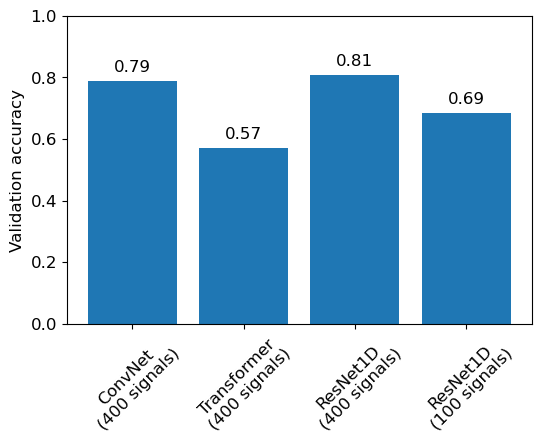

In [50]:
convnet_seq400 = '../data/train/240722_train_convnet_seqlen400_convnet_best_model.csv'
transformer_seq400 = '../data/train/240722_train_transformer_seqlen400_transformer_best_model.csv'
resnet1D_seq400 = '../data/train/240722_train_resnet1d_seqlen400_resnet_best_model.csv'
resnet1D_seq100 = '../data/train/240723_train_resnet1d_seqlen100_resnet_best_model.csv'
val_accs = []
labels = ['ConvNet\n(400 signals)', 'Transformer\n(400 signals)', 'ResNet1D\n(400 signals)', 'ResNet1D\n(100 signals)']
for file in [convnet_seq400, transformer_seq400, resnet1D_seq400, resnet1D_seq100]:
    with open(file, 'r') as infile:
        header = infile.readlines(1)
        for line in infile:
            line = line.strip().split('\t')
            #train_loss      train_acc       val_loss        val_acc
            val_accs.append(float(line[3]))

plt.figure(figsize=(6, 4))
for acc in val_accs:
    plt.bar(np.arange(0, len(val_accs)), val_accs, color = 'tab:blue')
    plt.xticks(np.arange(0, len(val_accs)), labels, rotation=45)
    plt.ylabel('Validation accuracy')
    plt.ylim(0,1)

for idx, value in enumerate(val_accs):
    plt.text(idx, float(value) + 0.02, str(round(float(value),2)), ha='center', va='bottom')

plt.savefig(f'{fig_outpath}Supp_Figure3C_nemo_model_comparison.pdf',  bbox_inches='tight')

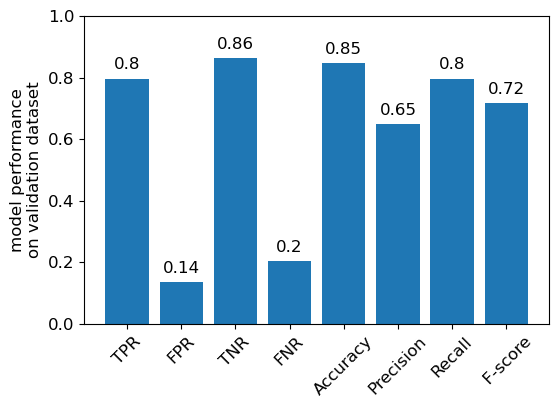

In [49]:
model_perform = '../data/train/240829_train_nuclei_addseq_seqlen400_50_seq_per_batch_step1_batch_256_epoch100_resnet_test_pred.tsv'
val_stat = []
with open(model_perform) as infile:
    for line in infile:
        line = line.strip().split('\t')
        val_stat.append(line)

labels = ['TPR', 'FPR', 'TNR', 'FNR', 'Accuracy', 'Precision', 'Recall', ' F-score']
plt.figure(figsize=(6, 4))
plt.bar(np.arange(0, len(val_stat[0])), [float(i) for i in val_stat[1]])
plt.xticks(np.arange(0, len(val_stat[0])), labels, rotation=45)
plt.ylabel('model performance\non validation dataset')
plt.ylim(0,1)

for idx, value in enumerate(val_stat[1]):
    plt.text(idx, float(value) + 0.02, str(round(float(value),2)), ha='center', va='bottom')

plt.savefig(f'{fig_outpath}Supp_Figure3D_nemo_model_performance.pdf',  bbox_inches='tight')

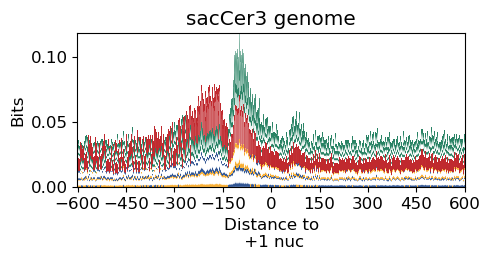

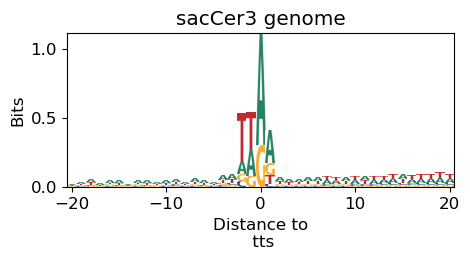

In [51]:
genome = '../data/sacCer3.fa'
nuc = '../data/Nucs_MittalPugh_sorted.bed'
tss = '../data/allTSS.bed'
tts = '../data/allCES.bed'

plotMotif(genome, nuc, outpath= fig_outpath, 
          prefix = f'Supp_Figure3E_sacCer3_nuc_1200', 
          extend=600, shift=0, center_name = '+1 nuc', space = 150)


plotMotif(genome, tts, outpath= fig_outpath, 
          prefix = f'Supp_Figure3F_sacCer3_tts_1200', 
          extend=20, shift=0, center_name = 'tts', space = 10)